
# IBM Data Science - Applied Data Science Capstone

## Finding Best Venues, Finding Best Neighbourhoods, Segmenting and Clustering Neighbourhoods in Mumbai City

![5_1506418321m.jpg](https://github.com/chinmaysalvi9/IBM_Data_Science-Applied_Data_Science_Capstone/blob/master/5_1506418321m.jpg?raw=true)

### Introduction

Mumbai is the capital city of the Indian state of Maharashtra. According to UN, as of 2018, Mumbai was the second most populous city in India after Delhi and the seventh most populous city in the world with a population of almost 20 million. In 2008, Mumbai was named an alpha world city. It has the highest number of millionaires and billionaires among all cities in India. Mumbai is home to three UNESCO World Heritage Sites: the Elephanta Caves, Chhatrapati Shivaji Maharaj Terminus, and the city's distinctive ensemble of Victorian and Art Deco buildings.

Mumbai is the financial, commercial and entertainment capital of India. It is also one of the world's top ten centres of commerce in terms of global financial flow, generating 6.16% of India's GDP and accounting for 25% of industrial output, 70% of maritime trade in India (Mumbai Port Trust and JNPT), and 70% of capital transactions to India's economy. Mumbai's billionaires had the highest average wealth of any city in the world in 2008. The city houses important financial institutions and the corporate headquarters of numerous Indian companies and multinational corporations. It is also home to some of India's premier scientific and nuclear institutes. The city also houses India's Hindi (Bollywood) and Marathi cinema industries. Mumbai's business opportunities attract migrants from all over India. Tourists from various countries around the world visit Mumbai.

With such a huge population and many venues for various purposes its often hard to choose the best one. Therefore, this project will help user decide best neighborhoods, best venues, etc.

### Problems:
* What are the places of Mumbai City that have top rated venues of the given category?
* What are the top-rated venues of Mumbai City of the given category?
* Which are the best places to stay if you prefer particular type of venues such as Gyms, Pubs, Italian Restaurant, Chinese Restaurant, etc. ?
* How are the neighborhoods around the Mumbai clustered?

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn.cluster as sc 
!pip install folium --quiet
import folium
import json
import requests
!pip install geocoder --quiet
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Importing Completed')

Importing Completed


In [2]:
# The code was removed by Watson Studio for sharing.

### Function to get venues of specific type

In [3]:
venues=list()

def get_venues_type(lat, lng, neigh, bor, query):
    RADIUS = 1000
    LIMIT = 50
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        RADIUS, 
        LIMIT)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        for v in results:
            if query in v['venue']['categories'][0]['name']:
                venues.append([(
                    bor,
                    neigh,
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['id'],
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) ])
    except:
        pass

### Function to get details of venue

In [4]:
details = list()

def get_venue_details(b, n, vdid):
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            vdid,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    result = requests.get(url).json()['response']['venue']
    try:        
        details.append([(b,n, result['name'], result['id'], result['likes']['count'], result['rating'], result['tips']['count'])])
    except:
        pass 

### Function to get top venues in neighborhood

In [5]:
top_venue=list()

def get_top_venues( nd, nlat, nlong):
    LIMIT = 50
    radius = 2000 
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        nlat, 
        nlong, 
        radius, 
        LIMIT)
    
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        for v in results:
            top_venue.append([(
                nd, 
                nlat, 
                nlong, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'])])
    except:
        pass

### Download dataset containing of Postal Code, Boroughs and Neighborhoods

In [6]:
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
df = pd.read_html(url)[0]
print(df.shape)
df.head()

(93, 4)


,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala\tAndheri,",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


### Renaming columns

In [7]:
df.columns = ['Neighborhood','Borough','Latitude','Longitude']

In dataframe df there are same values with name 'western Suburbs' and 'Western Suburbs' therefore following steps are taken to combine those values

In [8]:
for row, n in zip(df.iloc[:,1],range(df.shape[0])):
    try:
        df.iloc[n,1] = row.split(',')[1]
    except:
        df.iloc[n,1] = row.split(',')[0]
df.replace('western Suburbs','Western Suburbs',inplace=True)
df.iloc[92,1] = 'Thane'
print(df.shape)

(93, 4)


### Dataframe containing Neighborhoods, Boroughs, Latitude, Longitude

In [9]:
df.head(5)    

,Neighborhood,Borough,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,"Chakala\tAndheri,",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270


In [10]:
df.tail(5)

,Neighborhood,Borough,Latitude,Longitude
88,Parel,South Mumbai,18.990000,72.840000
89,Gowalia Tank,South Mumbai,18.962450,72.809703
90,Dava Bazaar,South Mumbai,18.946882,72.831362
91,Dharavi,Mumbai,19.040208,72.850850
92,Thane,Thane,19.200000,72.970000


### Fetching co-ordinates of Mumbai using geopy

In [11]:
address = 'Mumbai'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
mumbai_lat = location.latitude
mumbai_lng = location.longitude
print('The geograpical coordinate of Mumbai City are {}, {}.'.format(mumbai_lat, mumbai_lng))

The geograpical coordinate of Mumbai City are 18.9387711, 72.8353355.


### Map of Mumbai City with Neighborhoods superimposed on top

In [12]:
neigh_map = folium.Map([mumbai_lat+0.15,mumbai_lng+0.1],zoom_start=10)

for lat, lng, neigh in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    folium.CircleMarker(
        location=[lat,lng],
        radius=4,
        popup=neigh,
        color='#8417B9',
        fill=True,
        fill_color='#8417B9',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(neigh_map)

neigh_map

### Bar plot of Number of Neighborhoods in each Borough of Mumbai

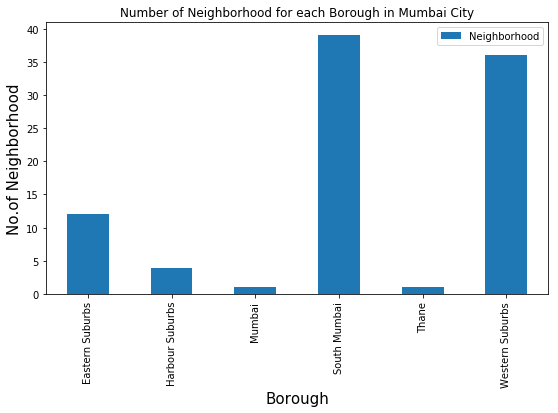

In [13]:
plt.figure(figsize=(9,5))
plt.title('Number of Neighborhood for each Borough in Mumbai City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
df.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

## Getting User Input to check certain category of venues

In [14]:
category = input('\nEnter Category ')


Enter Category Italian


### Dataframe containing Venue Name, ID, Co-ordinates, Category along with co-ordinates of Neighborhood

In [15]:
for lati, long, n, b in zip(df['Latitude'],df['Longitude'],df['Neighborhood'],df['Borough']):
    get_venues_type(lati, long, n, b, category)

query_venues = pd.DataFrame([item for venue_list in venues for item in venue_list])
query_venues.columns = ['Borough','Neighborhood','Neighborhood Latitude','Neighborhood Longitude', 
                         'Venue','Venue ID','Venue Latitude','Venue Longitude','Venue Category']

print(query_venues.shape)
query_venues.head()

(46, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Western Suburbs,Lokhandwala,19.130815,72.829270,Indigo Deli,5128e04ce4b07aedc43f68bc,19.136430,72.827553,Italian Restaurant
1,Western Suburbs,Lokhandwala,19.130815,72.829270,Levo,5262aeb311d2127e3e9fcb8b,19.133069,72.823040,Italian Restaurant
2,Western Suburbs,Lokhandwala,19.130815,72.829270,Apicius,4f72ab6c0039782e9bff2d1d,19.136980,72.833115,Italian Restaurant
3,Western Suburbs,Sahar,19.098889,72.867222,Stax,50782e31e4b07204c0420bb5,19.103659,72.871614,Italian Restaurant
4,Western Suburbs,Seven Bungalows,19.129052,72.817018,Levo,5262aeb311d2127e3e9fcb8b,19.133069,72.823040,Italian Restaurant


### Removing duplicate venues

In [16]:
query_venues.drop_duplicates(subset =['Venue','Venue Latitude','Venue Longitude'], keep = False, inplace = True)
print(query_venues.shape)
query_venues.head()

(22, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Western Suburbs,Lokhandwala,19.130815,72.829270,Indigo Deli,5128e04ce4b07aedc43f68bc,19.136430,72.827553,Italian Restaurant
2,Western Suburbs,Lokhandwala,19.130815,72.829270,Apicius,4f72ab6c0039782e9bff2d1d,19.136980,72.833115,Italian Restaurant
3,Western Suburbs,Sahar,19.098889,72.867222,Stax,50782e31e4b07204c0420bb5,19.103659,72.871614,Italian Restaurant
5,Western Suburbs,Bandstand Promenade,19.042718,72.819132,Maritime By San Lorenzo,5230378dbce6d10f7410f8a6,19.043696,72.819263,Italian Restaurant
6,Western Suburbs,Pali Hill,19.068000,72.826000,Out of the Blue,4b0587ccf964a52035a222e3,19.071756,72.825535,Italian Restaurant


### Map of Mumbai City with Venues of category given as INPUT by an USER superimposed on top 

In [17]:
venue_map = folium.Map([mumbai_lat+0.15,mumbai_lng+0.1],zoom_start=10)

for lt, lg, v in zip(query_venues['Venue Latitude'], query_venues['Venue Longitude'], query_venues['Venue']):
    folium.CircleMarker(
        location=[lt,lg],
        radius=4,
        popup=v,
        color='#0000ff',
        fill_color='#0000ff',
        fill=True,
        fill_opacity=0.7,
        parse_html=False
    ).add_to(venue_map)

venue_map

### Bar plot of Number of Venues in each Borough of Mumbai

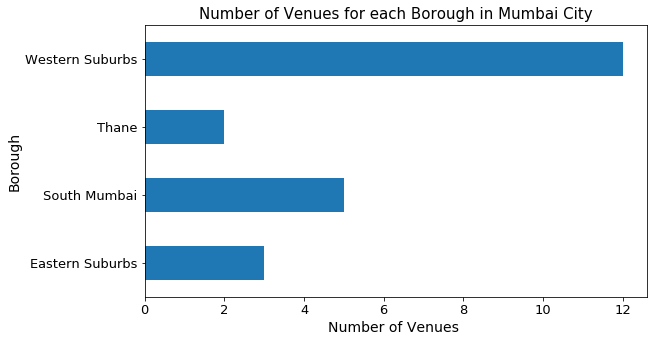

In [18]:
plt.figure(figsize=(9,5))
plt.title('Number of Venues for each Borough in Mumbai City',fontsize=15)
plt.ylabel('Borough', fontsize = 14)
plt.xlabel('Number of Venues '.format(category), fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
query_venues.groupby('Borough')['Venue ID'].count().plot(kind='barh')
plt.show()

### Bar plot of Number of Venues in each Neighborhood of Mumbai

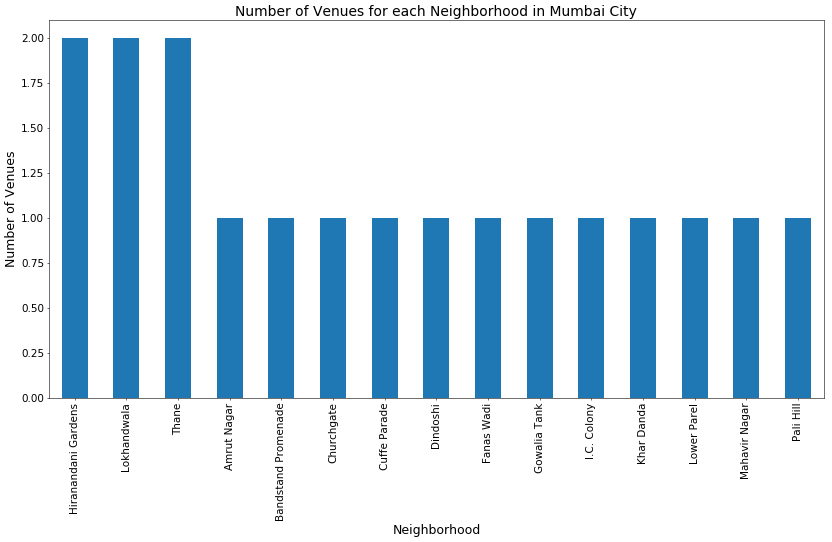

In [19]:
plt.figure(figsize=(20,10),dpi=50)
plt.title('Number of Venues for each Neighborhood in Mumbai City',fontsize=20)
plt.xlabel('Neighborhood', fontsize = 18)
plt.ylabel('Number of Venues', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
query_venues.groupby('Neighborhood')['Venue ID'].count().nlargest(15).plot(kind='bar')
plt.show()

### Getting details of Venues of category given as INPUT

In [20]:
for bor, neigh, vid in zip(query_venues['Borough'],query_venues['Neighborhood'],query_venues['Venue ID']):
    try:
        get_venue_details(bor, neigh, vid)
    except:
        continue

### Dataframe containing Details of Venue along with Borough and Neighborhood

In [21]:
venues_stats = pd.DataFrame([item for venue_list in details for item in venue_list])
venues_stats.columns = ['Borough','Neighborhood','Venue','Venue ID','Likes','Rating','Tips']
print(venues_stats.shape)
venues_stats.head()

(21, 7)


,Borough,Neighborhood,Venue,Venue ID,Likes,Rating,Tips
0,Western Suburbs,Lokhandwala,Indigo Deli,5128e04ce4b07aedc43f68bc,7,7.5,1
1,Western Suburbs,Lokhandwala,Apicius,4f72ab6c0039782e9bff2d1d,13,7.2,4
2,Western Suburbs,Sahar,Stax,50782e31e4b07204c0420bb5,17,7.6,3
3,Western Suburbs,Bandstand Promenade,Maritime By San Lorenzo,5230378dbce6d10f7410f8a6,8,6.9,3
4,Western Suburbs,Pali Hill,Out of the Blue,4b0587ccf964a52035a222e3,219,7.8,94


### Changing data type of columns

In [22]:
print(venues_stats.dtypes)
venues_stats['Likes'] = venues_stats['Likes'].astype('float64')
venues_stats['Tips'] = venues_stats['Tips'].astype('float64')
print(venues_stats.dtypes)

Borough          object
Neighborhood     object
Venue            object
Venue ID         object
Likes             int64
Rating          float64
Tips              int64
dtype: object
Borough          object
Neighborhood     object
Venue            object
Venue ID         object
Likes           float64
Rating          float64
Tips            float64
dtype: object


### Dataframe containing Neighborhood and Average Rating of Venue

In [23]:
neigh_avg_rating = venues_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neigh_avg_rating.columns=['Neighborhood','Avg Rating']
neigh_avg_rating.sort_values(['Avg Rating'],ascending=False, inplace=True)

print(neigh_avg_rating.shape)
neigh_avg_rating.head()

(18, 2)


,Neighborhood,Avg Rating
11,Lower Parel,8.1
7,Hiranandani Gardens,8.1
13,Pali Hill,7.8
2,Churchgate,7.7
15,Sahar,7.6


### Dataframe containing Borough and Average Rating of Venue

In [24]:
borough_avg_rating = venues_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
borough_avg_rating.columns=['Borough','Average Rating']
borough_avg_rating.sort_values(['Average Rating'],ascending=False).head()

print(borough_avg_rating.shape)
borough_avg_rating.head()

(4, 2)


,Borough,Average Rating
0,Eastern Suburbs,7.40
1,South Mumbai,7.28
2,Thane,7.30
3,Western Suburbs,7.10


### Dataframe containing BEST Neighborhood to stay 

In [25]:
best_neighs = neigh_avg_rating.head()
temp = query_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude']]
best_neighs = best_neighs.merge(temp, on = 'Neighborhood')
temp = venues_stats[['Venue','Rating','Likes']]
best_neighs = best_neighs.merge(temp, on = 'Venue')
print(best_neighs.shape)
best_neighs

(6, 9)


,Neighborhood,Avg Rating,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Rating,Likes
0,Lower Parel,8.1,18.995278,72.830000,Pronto,19.002965,72.828912,8.1,13.0
1,Hiranandani Gardens,8.1,19.118986,72.911767,Cafe Mangii,19.120260,72.907052,8.2,141.0
2,Hiranandani Gardens,8.1,19.118986,72.911767,Mia Cucina,19.120170,72.907217,8.0,90.0
3,Pali Hill,7.8,19.068000,72.826000,Out of the Blue,19.071756,72.825535,7.8,219.0
4,Churchgate,7.7,18.930000,72.820000,Salt Water Cafe,18.933500,72.826300,7.7,87.0
5,Sahar,7.6,19.098889,72.867222,Stax,19.103659,72.871614,7.6,17.0


### Map of Mumbai City with BEST NEIGHBORHOODS that have venues of given category superimposed on top 

In [26]:
best_neighs_map = folium.Map([mumbai_lat+0.15,mumbai_lng+0.1],zoom_start=10)

for la, lo, n in zip( best_neighs['Neighborhood Latitude'], best_neighs['Neighborhood Longitude'], best_neighs['Neighborhood']):
    folium.CircleMarker(
        location=[la,lo],
        radius=5,
        popup=n,
        color='#ff0000',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(best_neighs_map)
        
best_neighs_map

### Map of Mumbai City with BEST VENUES of category given as INPUT by an USER superimposed on top 

In [27]:
best_venues_map = folium.Map([mumbai_lat+0.15,mumbai_lng+0.1],zoom_start=10)

for lt, lg, v in zip(best_neighs['Venue Latitude'], best_neighs['Venue Longitude'], best_neighs['Venue']):
    folium.CircleMarker(
        location=[lt,lg],
        radius=5,
        popup=v,
        color='#800000',
        fill=True,
        fill_color='#800000',
        fill_opacity=1,
        parse_html=False
    ).add_to(best_venues_map)

best_venues_map

### Getting to Top Venues in each Neighborhoods

In [28]:
for lati, long, n in zip(df['Latitude'],df['Longitude'],df['Neighborhood']):
    try:
        get_top_venues(n,lati, long)
    except:
        continue

### Dataframe containing Top venues in each Neighborhood

In [29]:
top_venues = pd.DataFrame([item for top in top_venue for item in top])
top_venues.columns =['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
print(top_venues.shape)
top_venues.head()

(3628, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.1293,72.8434,Shawarma Factory,19.124591,72.840398,Falafel Restaurant
1,Amboli,19.1293,72.8434,Merwans Cake shop,19.119300,72.845418,Bakery
2,Amboli,19.1293,72.8434,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
3,Amboli,19.1293,72.8434,Hard Rock Cafe Andheri,19.135995,72.835335,American Restaurant
4,Amboli,19.1293,72.8434,Pizza Express,19.131893,72.834668,Pizza Place


### Unique Categories of Venues 

In [30]:
top_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(top_venues['Venue Category'].unique())))

There are 187 uniques categories.


### One-hot encoding to get column for each category

In [31]:
onehot = pd.get_dummies(top_venues[['Venue Category']], prefix="", prefix_sep="")
onehot.head()

,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Theme Park,Toy / Game Store,Track,Track Stadium,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Women's Store,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Changing position of columns

In [32]:
onehot.drop(['Neighborhood'], axis=1,inplace=True)
onehot['Neighborhood'] = df['Neighborhood'] 
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
print(onehot.shape)
onehot.head()

(3628, 187)


,Neighborhood,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,...,Theme Park,Toy / Game Store,Track,Track Stadium,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Women's Store,Zoo
0,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Chakala\tAndheri,",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,D.N. Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Four Bungalows,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Lokhandwala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dataframe of one-hot encoded categories for each Neighborhood

In [33]:
neigh_cat = onehot.groupby('Neighborhood').mean().reset_index()
print(neigh_cat.shape)
neigh_cat.head()

(93, 187)


,Neighborhood,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,...,Theme Park,Toy / Game Store,Track,Track Stadium,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Women's Store,Zoo
0,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agripada,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Altamount Road,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amrut Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dataframe consisting of Top 10 venue categories in each Neighborhood

In [34]:
num = 10
indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [35]:
top_10= pd.DataFrame(columns=columns)
top_10['Neighborhood'] = neigh_cat['Neighborhood']

for ind in np.arange(neigh_cat.shape[0]):
    row = neigh_cat.iloc[ind, :]
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    top_10.iloc[ind, 1:] = row_cat_sorted.index.values[0:num] 

top_10.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarey Milk Colony,BBQ Joint,Zoo,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
1,Agripada,Seafood Restaurant,Zoo,Dhaba,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
2,Altamount Road,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
3,Amboli,Falafel Restaurant,Zoo,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Event Space,Electronics Store,Donut Shop
4,Amrut Nagar,Pub,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner


### Applying KMeans Clustering Algorithm 

In [36]:
temp = neigh_cat.drop('Neighborhood', 1)

k = 5
kmeans = sc.KMeans(n_clusters=k, random_state=0).fit(temp)
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 3, 0, 0, 0, 1, 0], dtype=int32)

### Inserting Cluster Label in for each Neighborhood 

In [37]:
top_10.insert(0, 'Cluster Labels', kmeans.labels_)
top_10.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Aarey Milk Colony,BBQ Joint,Zoo,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
1,0,Agripada,Seafood Restaurant,Zoo,Dhaba,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
2,1,Altamount Road,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
3,0,Amboli,Falafel Restaurant,Zoo,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Event Space,Electronics Store,Donut Shop
4,3,Amrut Nagar,Pub,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner


### Merging dataframe to create dataframe containing TOP 10 categories of Venues in each Neighborhood along with its location details

In [38]:
cluster = df
cluster = cluster.join(top_10.set_index('Neighborhood'), on='Neighborhood')

cluster.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,19.129300,72.843400,0,Falafel Restaurant,Zoo,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Event Space,Electronics Store,Donut Shop
1,"Chakala\tAndheri,",Western Suburbs,19.111388,72.860833,0,Bakery,Zoo,Food,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,0,Mughlai Restaurant,Zoo,Dim Sum Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
3,Four Bungalows,Western Suburbs,19.124714,72.827210,0,American Restaurant,Zoo,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
4,Lokhandwala,Western Suburbs,19.130815,72.829270,0,Pizza Place,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner


### Map of Mumbai City with CLUSTERs superimposed on top 

In [39]:
cluster_map = folium.Map([mumbai_lat+0.15,mumbai_lng+0.1],zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lt, ln, nd, c in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels']):
    label = folium.Popup(str(nd) + ' Cluster ' + str(c), parse_html=True)
    folium.CircleMarker(
        [lt, ln],
        radius=5,
        popup=label,
        color=rainbow[c-1],
        fill=True,
        fill_color=rainbow[c-1],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map

### CLUSTER 1

In [40]:
cluster.loc[cluster['Cluster Labels'] == 0, cluster.columns[[1] + list(range(5, cluster.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Western Suburbs,Falafel Restaurant,Zoo,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Event Space,Electronics Store,Donut Shop
1,Western Suburbs,Bakery,Zoo,Food,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
2,Western Suburbs,Mughlai Restaurant,Zoo,Dim Sum Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
3,Western Suburbs,American Restaurant,Zoo,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
4,Western Suburbs,Pizza Place,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
5,Western Suburbs,Sandwich Place,Zoo,Dhaba,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
6,Western Suburbs,Pizza Place,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
7,Western Suburbs,Brewery,Zoo,Dim Sum Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
10,Western Suburbs,Multiplex,Zoo,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
12,Western Suburbs,Ice Cream Shop,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop


### CLUSTER 2

In [41]:
cluster.loc[cluster['Cluster Labels'] == 1, cluster.columns[[1] + list(range(5, cluster.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Western Suburbs,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
14,Western Suburbs,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
16,Western Suburbs,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
19,Western Suburbs,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
44,Eastern Suburbs,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
46,Eastern Suburbs,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
49,Harbour Suburbs,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
53,South Mumbai,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
54,South Mumbai,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
56,South Mumbai,Indian Restaurant,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop


### CLUSTER 3

In [42]:
cluster.loc[cluster['Cluster Labels'] == 2, cluster.columns[[1] + list(range(5, cluster.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Western Suburbs,Chinese Restaurant,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
11,Western Suburbs,Chinese Restaurant,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
21,Western Suburbs,Chinese Restaurant,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
27,Western Suburbs,Chinese Restaurant,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
41,Eastern Suburbs,Chinese Restaurant,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
69,South Mumbai,Chinese Restaurant,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
79,South Mumbai,Chinese Restaurant,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner


### CLUSTER 4

In [43]:
cluster.loc[cluster['Cluster Labels'] == 3, cluster.columns[[1] + list(range(5, cluster.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Western Suburbs,Pub,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
34,Western Suburbs,Pub,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
37,Eastern Suburbs,Pub,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
42,Eastern Suburbs,Pub,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner
43,Eastern Suburbs,Pub,Zoo,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner


### CLUSTER 5

In [44]:
cluster.loc[cluster['Cluster Labels'] == 4, cluster.columns[[1] + list(range(5, cluster.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Harbour Suburbs,Hotel,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
51,Harbour Suburbs,Hotel,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
57,South Mumbai,Hotel,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
63,South Mumbai,Hotel,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
68,South Mumbai,Hotel,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
84,South Mumbai,Hotel,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
87,South Mumbai,Hotel,Zoo,Dhaba,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop


### Result 
Solutions to the problems given above in the Problems section: 
1.	The neighborhoods of Mumbai City that have top rated venues of the given category.
  * Lower Parel
  *	Hiranandani Gardens
  *	Pali Hill
  *	Churchgate
  * Sahar
    
    
2.	The top-rated venues of Mumbai City of the given category are:
  *	Pronto
  *	Café Mangli
  *	Mia Cucina
  *	Out of the Blue
  *	Salt Water Café
  *	Stax


3.	Best places to stay if you prefer particular type of venues:
  * Lower Parel
  *	Hiranandani Gardens
  *	Pali Hill
  *	Churchgate
  *	Sahar
  
  
4.	Neighborhoods around Mumbai can be clustered into 5 types with top visited venues:
  * Cluster 1: Mixed top visited venues
  * Cluster 2: Indian Restaurant, Zoo, Dhaba, Fast Food Restaurant, etc.
  * Cluster 3: Chinese Restaurant, Dhaba, Fast Food Restaurant, Farmers Market, etc.
  * Cluster 4: Pub, Zoo, Dessert Shop, Farmers Market, etc.
  * Cluster 5: Hotel, Zoo, Dhaba, Fast Food Restaurant, etc.

### Conclusion
Best venues and neighborhoods for the category of venue given as Input were found and successfully visualized on maps and also using plots. KMeans Clustering model was built and used to successfully cluster neighborhoods around the Mumbai City. 
There is always room for improvement and hence the solution provided above can also be improved to get best results depending upon the data.